In [72]:
import torch
from tqdm import tqdm
import numpy as np
import sys
import matplotlib.pyplot as plt
from utils import checkpoint, warning
import utils
import MCHMC, MCLMC
import autotuning as aut
import integration_schemes as integ
import functions as funct
import visualization as vis
import importlib
from blackjax.diagnostics import effective_sample_size
import pandas as pd

np.random.seed(0)

In [141]:
# questo serve altrimenti non usa l'ultima versione dei file .py
importlib.reload(utils)
importlib.reload(MCHMC)
importlib.reload(MCLMC)
importlib.reload(aut)
importlib.reload(integ)
importlib.reload(funct)
importlib.reload(vis)

<module 'visualization' from '/home/ubuntu/MCHMC/visualization.py'>

# Information Theory Project

Cose da **fare**:
- Sistemare gridsearch (metrica per valutare la migliore combinazione L-eps)
- Calcolare ESS (200/n) per confronto algoritmi (tabella che ci interessa)
- Implementare altre funzioni, abbiamo solo bimodal e cauchy (che io direi di lasciare perdere dato che è incasinata)
- Implementare NUTS con NumPyro/PyMC
- Slide

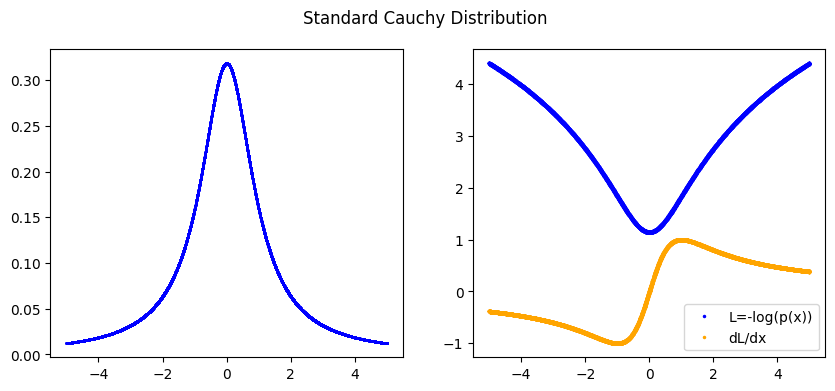

In [3]:
x = np.random.uniform(low=-5, high=5, size=(10000, 1))
L = -np.log(funct.standard_cauchy(x).detach().numpy())
nablaL = integ.grad_log_likelihood(x, funct.standard_cauchy).numpy()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(x, funct.standard_cauchy(x).numpy(), 'o', c='blue', ms=1)

axes[1].plot(x, L, 'o', color='blue', markersize=1.5, label='L=-log(p(x))')
axes[1].plot(x, nablaL, 'o', color='orange', markersize=1.5, label='dL/dx')
axes[1].legend()

fig.suptitle('Standard Cauchy Distribution')
plt.show()

/home/ubuntu/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:789: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


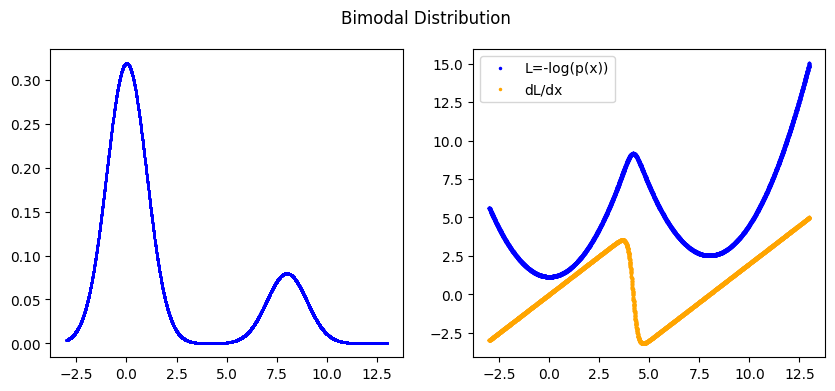

In [4]:
x = np.random.uniform(low=-3, high=13, size=(10000, 1))
L = -np.log(funct.bimodal(x).to("cpu").detach().numpy())
nablaL = integ.grad_log_likelihood(x, funct.bimodal).numpy()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].plot(x, funct.bimodal(x).to("cpu").numpy(), 'o', c='blue', ms=1)

axes[1].plot(x, L, 'o', color='blue', markersize=1.5, label='L=-log(p(x))')
axes[1].plot(x, nablaL, 'o', color='orange', markersize=1.5, label='dL/dx')
axes[1].legend()

fig.suptitle('Bimodal Distribution')
plt.show()

## Microcanonical Hamiltonian Montecarlo

## Simple algorithm test for debugging

For small dimensions for each type of distribution check that priors, tensor shapes, gradients and logL make sense!!! 

In [13]:
N_samples = 1
dim = 1000
l = np.sqrt(2)
e = l*0.75
X, *_ = MCHMC.MCHMC_bounces(d=dim, N=N_samples, L=l, epsilon=e, fn=funct.bimodal)

##### NLOGL 
tensor([-0.], device='cuda:0', grad_fn=<NegBackward0>)
##### GRAD 
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        -0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

ValueError: Expected value argument (Tensor of shape (1, 1000)) to be within the support (IndependentConstraint(Real(), 1)) of the distribution MultivariateNormal(loc: torch.Size([1000]), covariance_matrix: torch.Size([1000, 1000])), but found invalid values:
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
       device='cuda:0', grad_fn=<TransposeBackward0>)

### Parameters optimization - Bimodal distribution

In [122]:
# Optimizing epsilon 
N = 200
d = 100

eps_values, sigma_effs, _ = aut.tune_eps(d=d, N=N, L=10, fn=funct.bimodal, algorithm=MCHMC.MCHMC_bounces, iterations=5, debug=False)
sigma_eff = np.mean(sigma_effs)
eps_opt = np.mean(eps_values)
print(f'Optimal epsilon: {eps_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7fc89e52f640> with 200 steps, updating epsilon


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.15s/it]

Optimal epsilon: 6.113369464874268


In [123]:
# Optimizing L
L_values = aut.tune_L(sigma_eff, eps_opt, d, N=N, fn=funct.bimodal, algorithm=MCHMC.MCHMC_bounces, iterations=5)
L_opt = np.mean(L_values)
print(f'Optimal L: {L_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7fc89e52f640> with 200 steps, updating L


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.12s/it]

Optimal L: 11.717751830412821


We have implemented the procedure reported in the paper for the tuning of $\epsilon$, but it leads to strange values. Here we try to perform a gridsearch based on the naive idea that $\epsilon = n \cdot L$, with $n \sim 7.5$.

**in realta ora dovrebbe funzionare il tuning di epsilon!!**

In [ ]:
N_grid = 5
N_samples = 1000
dim = 2
iterations = 10
n = np.linspace(0.7, 0.8, N_grid)
eps = n * L_opt
gfig, gax = plt.subplots(N_grid, figsize=(4, 3*N_grid))
records = []

for i in tqdm(range(len(eps))):
    e = eps[i]
    gax[i].set_title(rf'$L = {L_opt:.1f}$ $\epsilon = {e:.1f}$')
    Xt = np.zeros((iterations, N_samples+1, dim))
    
    for j in range(iterations):
        X, *_ = MCHMC.MCHMC_bounces(d=dim, N=N_samples, L=L_opt, epsilon=e, fn=funct.bimodal)
        X = X.to("cpu").detach().numpy()
        Xt[j] = X
        
    x = np.linspace(-20, 20, 10000)
    record = {}
    record['L'] = L_opt
    record['epsilon'] = e
    record['L/e'] = L_opt/e
    Xt = Xt.reshape(iterations * (N_samples+1), dim)
    gax[i].hist(Xt[:,0], density=True, alpha=0.5, bins=100, color='blue', label='MCHMC bounces')
    gax[i].scatter(x, funct.bimodal(x).to("cpu").numpy(), color='orange', s=1, label='exact')
    gax[i].legend()
    #compute mean, stdev
    record['mean'] = Xt[:, 0].mean()
    record['std'] = Xt[:, 0].std()
    #Other metrics??
    records.append(record)
plt.tight_layout()
plt.savefig('grid.svg')
plt.show()

In [ ]:
df = pd.DataFrame(records)
df.head(len(df))

The mean should be $0.2\times 8 = 1.6$ and the standard deviation should be $\approx 3.35$

In [124]:
n_chains = 5
X = []
for i in range(n_chains):
    Xi, *_ = MCHMC.MCHMC_bounces(d=100, N=5000, L=L_opt, epsilon=eps_opt, fn=funct.bimodal, pbar=True)
    X.append(Xi)

X = torch.cat(X, dim=0)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:50<00:00, 99.22it/s]


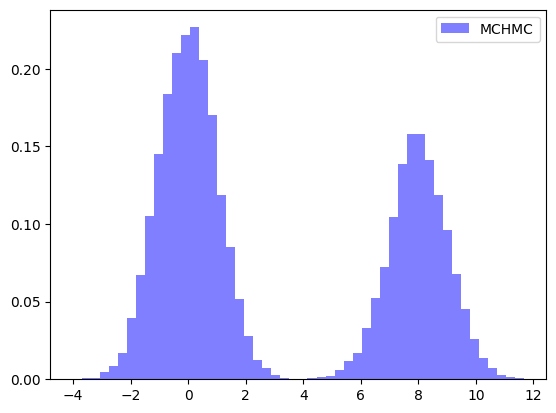

In [143]:
#X = X.to("cpu").detach().numpy()
x = np.linspace(-20, 20, 10000)
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCHMC')
#plt.scatter(x, np.exp(funct.bimodal(x).to("cpu").numpy()), color='orange', s=1, label='exact')
plt.legend()
plt.show()

---------------

### Parameters optimization - Ill conditioned Gaussian distribution

In [60]:
# get the covariance matrix of the distribution 
d = 100
cov = funct.get_ill_cov(d)
print(cov.shape)

(100, 100)


In [80]:
# Optimizing epsilon 
N = 200
d = 100

eps_values, sigma_effs, _ = aut.tune_eps(d=d, N=N, L=5, fn=funct.ill_cond_gaussian, algorithm=MCHMC.MCHMC_bounces, iterations=5, debug=False, cov=cov)
sigma_eff = np.mean(sigma_effs)
eps_opt = np.mean(eps_values)
print(f'Optimal epsilon: {eps_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7fc8f051eef0> with 200 steps, updating epsilon


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.18s/it]

Optimal epsilon: 0.45095106959342957


In [81]:
# Optimizing L
L_values = aut.tune_L(sigma_eff, eps_opt, d, N=N, fn=funct.ill_cond_gaussian, algorithm=MCHMC.MCHMC_bounces, iterations=5, cov=cov)
L_opt = np.mean(L_values)
print(f'Optimal L: {L_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7fc8f051eef0> with 200 steps, updating L


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.26s/it]

Optimal L: 7.819301496881275


In [83]:
X, *_ = MCHMC.MCHMC_bounces(d=d, N=20000, L=L_opt, epsilon=eps_opt, fn=funct.ill_cond_gaussian, pbar=True, cov=cov)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:57<00:00, 169.70it/s]


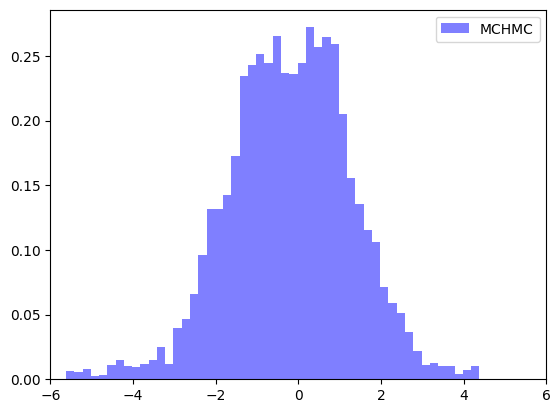

In [86]:
X = X.to("cpu").detach().numpy()
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCHMC')
plt.xlim(-6,6)
plt.legend()
plt.show()

## Langevin-like Hamiltonian Montecarlo

### Parameter optimization - Bimodal distribution 

In [ ]:
# Optimizing epsilon
L = torch.tensor(10, device=utils.choose_device())
eps_values, sigma_effs = aut.tune_eps(d=1000, N=300, L=L, fn=funct.bimodal, algorithm=MCLMC.MCLMC, iterations=5)

epsilon_opt = eps_values.mean()
sigma_eff = sigma_effs.mean()
print(f'Optimal epsilon: {epsilon_opt}')

In [ ]:
L_values = aut.tune_L(sigma_eff, epsilon_opt, d=1000, N=300, fn=funct.bimodal, algorithm=MCLMC.MCLMC, iterations=5, debug=False, cauchy=False)

L_opt = L_values.mean()
print(f'Optimal L: {L_opt}')

In [ ]:
X, *_ = MCLMC.MCLMC(d=1000, N=10000, L=L_opt, epsilon=epsilon_opt, fn=funct.bimodal)

In [ ]:
X = X.to("cpu").detach().numpy()

x = np.linspace(-20, 20, 10000)
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCLMC')
plt.scatter(x, funct.bimodal(x).to("cpu").numpy(), color='orange', s=1, label='exact')
plt.legend()
plt.show()

In [ ]:
X, *_ = MCLMC.MCLMC(d=2, N=10000, L=L_opt, epsilon=epsilon_opt, fn=funct.bimodal)

X = X.to("cpu").detach().numpy()
x = np.linspace(-20, 20, 10000)
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCLMC')
plt.scatter(x, funct.bimodal(x).to("cpu").numpy(), color='orange', s=1, label='exact')
plt.legend()
plt.show()

------------

### Parameters optimization - Ill conditioned Gaussian distribution

In [92]:
# Optimizing epsilon 
N = 200
d = 100

eps_values, sigma_effs, _ = aut.tune_eps(d=d, N=N, L=torch.tensor(5), fn=funct.ill_cond_gaussian, algorithm=MCLMC.MCLMC, iterations=5, debug=False, cov=cov)
sigma_eff = np.mean(sigma_effs)
eps_opt = np.mean(eps_values)
print(f'Optimal epsilon: {eps_opt}')


Running 5 iterations of <function MCLMC at 0x7fc89f65bf40> with 200 steps, updating epsilon


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]


Optimal epsilon: 0.8786865472793579


In [93]:
# Optimizing L
L_values = aut.tune_L(sigma_eff, eps_opt, d, N=N, fn=funct.ill_cond_gaussian, algorithm=MCHMC.MCHMC_bounces, iterations=5, cov=cov)
L_opt = np.mean(L_values)
print(f'Optimal L: {L_opt}')


Running 5 iterations of <function MCHMC_bounces at 0x7fc89f377a30> with 200 steps, updating L


Running iterations: 100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.28s/it]

Optimal L: 11.622281967648869


In [94]:
X, *_ = MCHMC.MCHMC_bounces(d=d, N=20000, L=L_opt, epsilon=eps_opt, fn=funct.ill_cond_gaussian, pbar=True, cov=cov)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:59<00:00, 167.79it/s]


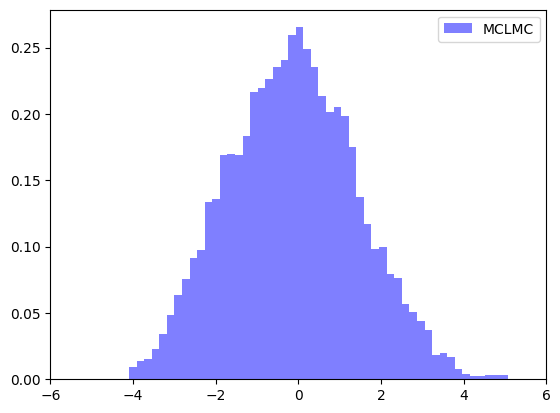

In [95]:
X = X.to("cpu").detach().numpy()
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCLMC')
plt.xlim(-6,6)
plt.legend()
plt.show()

## NUTS
